# Pirma Dalis
Pradedame importuodami mums reikalingas bibliotekas. Šiuo atveju mums rūpi "nmigen" biblioteka ir jos posistemės bei python standartine "os" biblioteka, leidžianti naudotis komandos eilutėmis per python programas.

In [148]:
from nmigen import *
from nmigen.back.pysim import Simulator, Delay, Settle
import os
from nmigen.back import verilog

Pradedame nuo testų.
Mūsų pirmas skaitmeninės logikos modulis su nmigen bus papraščiausias OR gate. Jam paduosime dvi įvestis (a,b) ir vieną išvestį (c).
nmigen įrankiu testai aprašomi kaip atskiri procesai kurių metu 'yield' raktažodžiu žymimos operacijos susijusios su skaitmeninės logikos operacijomis. Jeigu yield raktažodžio nėra - eilutė nera simuliacijos dalis, o papraščiausias python kodas.

Šiuo atveju, turėsime modulį kuris vadinsis 'top' ir prilyginsime jo įvestis a = 0 ir b = 1, tada palauksime 1 nanosekundę, prilyginsime b įvestį 0, vėl palauksime ir tada a įvestį prilyginsime 1.

In [149]:
def testbench():
    yield top.a.eq(0)    # a = 0
    yield top.b.eq(1)    # b = 1
    yield Delay(1e-9)    # 1 ns palaukimas
    
    yield top.b.eq(0)    # b = 0
    yield Delay(1e-9)    # 1 ns palaukimas
    
    yield top.a.eq(1)    # b = 1
    yield Delay(1e-9)    # 1 ns palaukimas

Toliau aprašome savo skaitmeninės logikos mudulį. Jis aprašomas kaip klasė kurios objektus vėliau generuosime.

In [150]:
class OR_Gate(Elaboratable): # Kuriame klasę OR_Gate kuri paveldi 'Elaboratable' klasę
    
    def __init__(self):     # aprašomos modulio įvestys ir išvestys (kas yra kas, įrankis pats išsiaiškins)
        self.a = Signal()   # sukuriamas naujas signalas a
        self.b = Signal()   # sukuriamas naujas signalas b
        self.c = Signal()   # sukuriamas naujas signalas c

        
    def elaborate(self, platform: str):    # aprašoma modulio logika
        m = Module()                       # kuriamas naujas modulis
        m.d.comb += self.c.eq(self.a | self.b)    # c = a | b ir šitą išraišką pridedame prie modulio kombinacinės logikos
        return m

Instancijuojame OR_Gate klasės objektą 'top' ir paleidžiame simuliatorių, paduodaji jam top modulį bei testavimo metodą.
Tuo pačiu sugeneruojame .vcd file'ą pažiūrėti signalų laiko grafą "test.vcd"

In [151]:
top = OR_Gate()

sim = Simulator(top) # pridedame simuliuojamą modulį

with sim.write_vcd("test.vcd", "test.gtkw", traces=[top.a, top.b, top.c]):
    sim.add_process(testbench) # pridedame simuliuojamo modulio testų funkciją
    sim.run()

Kviečiame GTKWave įrankį. Ši eilutė lygi cmd atidarymui šioje direktorijoje ir 'gtkwave test.vcd' įvedimui.
Pabaigus žiūrėti, išjunkite GTKWave įrankį, kad galėtumėte tęsti programą.

In [152]:
os.system('cmd /k gtkwave test.vcd')

0

Paspaudę ant 'top' modulio ir nusitempe signalus ant laiko diagramos (arba visus pažymėję ir paspaude "Append" mygtuką turėtumėte matyti šį vaizdą (gali reikėti pakeisti laiko diagramos mastelį su zoom in/zoom out mygtukais arba ctrl+pelės ratukas)
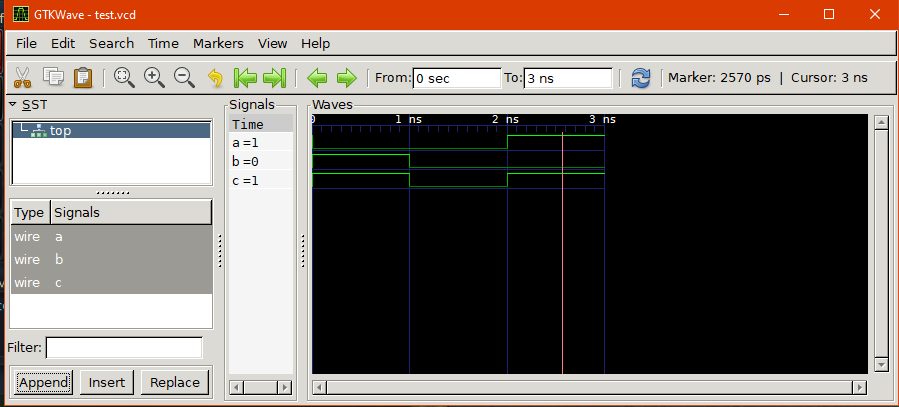

Toliau generuojame Verilog file'ą. Per naują instancijuojame top objektą, naudojame nmigen convert funkciją, aprašome kokios yra modulio aukščiausio lygio "top module" įvestis ir išvestys (biblioteka pati susigaudys, kas yra įvestis, kas yra išvestis).

Galiausiai atspaudinsime sugeneruotą verilog file'ą ir išsaugosime esamoje direktorijoje.

In [153]:
top = OR_Gate()
output = verilog.convert(top, ports=[top.a, top.b,top.c],strip_internal_attrs=True)
with open("or_gate.v", "w") as f:
    f.write(output)
    
print(output)

/* Generated by Yosys 0.9 (git sha1 1979e0b1, i686-w64-mingw32.static-g++ 5.5.0 -Os) */

module top(b, c, a);
  wire \$1 ;
  input a;
  input b;
  output c;
  reg c;
  assign \$1  = a | b;
  always @* begin
    c = 1'h0;
    c = \$1 ;
  end
endmodule



Atliekame pakeitimą. Dabar apart kombinacinės logikos, c signalą prilyginsime kaip sinchroninės logikos dalį ir pažiūrėsime skirtumus.

In [154]:
class OR_Gate_SYNC(Elaboratable): # Kuriame klasę OR_Gate kuri paveldi 'Elaboratable' klasę
    
    def __init__(self):     # aprašomos modulio įvestys ir išvestys (kas yra kas, įrankis pats išsiaiškins)
        self.a = Signal()   # sukuriamas naujas signalas a
        self.b = Signal()   # sukuriamas naujas signalas b
        self.c = Signal()   # sukuriamas naujas signalas c

        
    def elaborate(self, platform: str):    # aprašoma modulio logika
        m = Module()                       # kuriamas naujas modulis
        m.d.sync += self.c.eq(self.a | self.b)    # c = a | b ir šitą išraišką pridedame prie modulio kombinacinės logikos
        return m

In [155]:
top = OR_Gate_SYNC()

sim = Simulator(top) # pridedame simuliuojamą modulį

#sim.add_process(testbench) # pridedame simuliuojamo modulio testų funkciją

with sim.write_vcd("test_sync.vcd", "test_sync.gtkw", traces=[top.a, top.b, top.c]):
    sim.add_clock( 2.5e-9 )
    sim.add_sync_process(testbench)
    sim.run()

In [156]:
os.system('cmd /k gtkwave test_sync.vcd')

0

Matote pokytį? Dabar signalas pasikeitė tik ties sekančiu kylančiu clock'u, jeigu a arba b įvestys buvo teigiamos tuo laiko momentu.
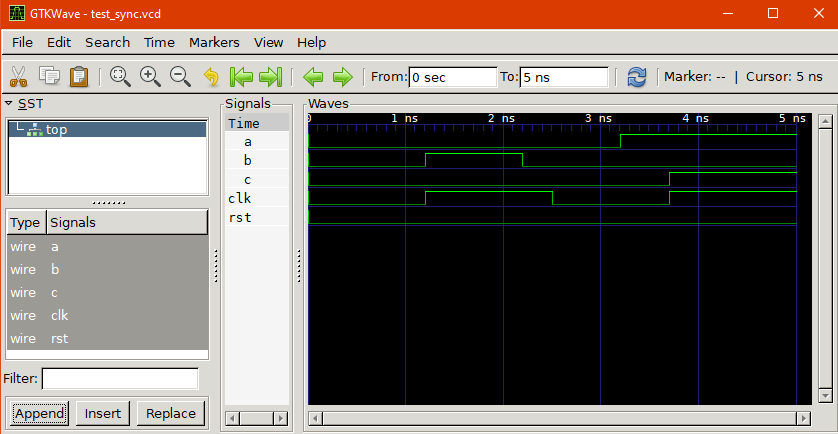

Pergeneruojame verilog kodą ir taip pat paanalizuojame skirtumus

In [161]:
top = OR_Gate_SYNC()
output = verilog.convert(top, ports=[top.a, top.b,top.c],strip_internal_attrs=True)
with open("or_gate_sync.v", "w") as f:
    f.write(output)
    
print(output)

/* Generated by Yosys 0.9 (git sha1 1979e0b1, i686-w64-mingw32.static-g++ 5.5.0 -Os) */

module top(b, c, clk, rst, a);
  wire \$1 ;
  input a;
  input b;
  (* init = 1'h0 *)
  output c;
  reg c = 1'h0;
  reg \c$next ;
  input clk;
  input rst;
  assign \$1  = a | b;
  always @(posedge clk)
      c <= \c$next ;
  always @* begin
    \c$next  = c;
    \c$next  = \$1 ;
    (* src = "C:\\Users\\Felkin\\Anaconda3\\lib\\site-packages\\nmigen\\hdl\\xfrm.py:530" *)
    casez (rst)
      1'h1:
          \c$next  = 1'h0;
    endcase
  end
endmodule



Kaip matome, buvo pridėtas papildomas registras ir reakcija į teigiamą clock'o pokytį (posedge clk). Dabar logika saugo c reikšmę ir ją keičia tik teigiamo clock'o pokyčio metu. Vos 4 simbolių pakeitimas python kode ir turime drastiškai pakitusią skaitmeninę logiką.

# Antra dalis - Dekoderis

Norint geriau suprasti nMigen galimybes, realizuosime pirmo laboratorinio darbo metu darytą dekoderį.

In [197]:
class Decoder(Elaboratable):
    
    def __init__(self):     
        self.a = Signal(6)  # aprašome 6 bitų vektorinį signalą
        self.y = Signal()
        
    def elaborate(self, platform: str): 
        m = Module()

        m.d.comb += self.y.eq(0) # 'by default' y = 0
        
        with m.Switch(self.a):           # jeigu a
            with m.Case(0, 1, 2, 10):    # priklauso {0,1,2,10}
                m.d.comb += self.y.eq(1) # tada y = 1
        return m

Norint geriau ištestuoti dekoderį, sukūrsime įmantresnę testavimo funkciją:
Aprašome funkciją 'check_case' kuri turi vieną įvestį (a) ir antrą funkiją 'decoder_testbench' kurį kvies check_case su įvairiomis a reikšmėmis sukant ciklą.

In [198]:
def check_case(a): # prilyginti modulio a įvesti funkcijos argumentui a ir palaukti 1 ns
    yield top.a.eq(a)
    yield Delay(1e-9)

def decoder_testbench(): # kviesti check_case su visais argumentais iš test_cases masyvo
    test_cases = [0,3,10,33]
    for test in test_cases:
        yield from check_case(test)

In [199]:
top = Decoder()

sim = Simulator(top)

with sim.write_vcd("test_decoder.vcd", "test_decoder.gtkw", traces=[top.a,top.y]):
    sim.add_process(decoder_testbench)
    sim.run()
    
os.system('cmd /k gtkwave test_decoder.vcd')

0

Turėtume matyti šį vaizdą. y išvestis lygi 1, kai įvestis lygi 0 arba 10
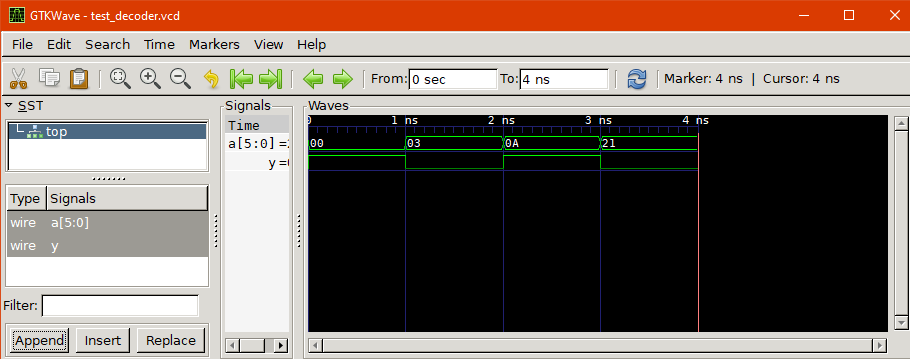

In [200]:
top = Decoder()
output = verilog.convert(top, ports=[top.a,top.y],strip_internal_attrs=True)
with open("decoder.v", "w") as f:
    f.write(output)
    
print(output)

/* Generated by Yosys 0.9 (git sha1 1979e0b1, i686-w64-mingw32.static-g++ 5.5.0 -Os) */

module top(y, a);
  input [5:0] a;
  output y;
  reg y;
  always @* begin
    y = 1'h0;
    y = 1'h0;
    (* src = "<ipython-input-197-d4486dc7d04e>:12" *)
    casez (a)
      /* src = "<ipython-input-197-d4486dc7d04e>:13" */
      6'h00, 6'h01, 6'h02, 6'h0a:
          y = 1'h1;
    endcase
  end
endmodule

